# <i>COMXXX - Computers and Music</i> <br /> <br />  <b>Synthesizer</b> 
<div align="right"><a href="link">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>
<br />

In [1]:
%matplotlib inline
import ipywidgets as widgets
from numpy.fft import fft, ifft, hfft
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio
import import_ipynb
from Helpers import *

figsize=(10,5)
linewidth=2.5
matplotlib.rcParams.update({'font.size': 16})

importing Jupyter notebook from Helpers.ipynb


In [2]:
fs = 44100
time = np.linspace(0, 2, 2*fs)
samples = np.arange(2*fs)
fourier = np.linspace(0, .2*np.pi, 2*fs)

A synthesizer is an electronic musical instrument that allows to generate audio signals. It generally presents as a piano keyboard, along with many knobs for tuning parameters, grouped in sections that correspond to the different stages of shaping the sound of the synthesizer. The first stage is to generate a sound wave, and is called an **oscillator**. This can be done in several ways, like by adding sines, or modulating them together. The wave is then sent to the next stages which are filters changing its shape, for instance low frequency oscillators (**LFOs**), equalizers (EQs), etc.

<img src="https://images-na.ssl-images-amazon.com/images/I/71KdQUycyQL._AC_SL1500_.jpg" alt="Drawing" style="width: 35%;"/>

In this notebook, we will implement 2 types of oscillators: the additive oscillator and the FM oscillator. 

## 1. Additive and digital oscillators

According to Fourier theory, summing up sines allows to create any waveform. An additive oscialltor hence generates waveforms by adding sines with different amplitudes, phases, and angular frequencies together. The created waveform is periodic and can also be defined by an amplitude $A$, an angular frequency $\omega_c$ and a phase $\phi$. 

\begin{align*}
    wave[A, \omega_c, \phi; n]
\end{align*}

An oscillator containing an additive oscialltor is also called an additive synthesizer, and typically features 4 basic wavesforms:
- The sine wave
- The square wave
- The sawtooth wave
- The triangle wave

that can each be fully described by the above cited parameters.

With the coming of digital technology, summing sines was no longer needed to generate waveforms as the synthesizer could simply use mathematical functions to draw the shape of the wave.

Here we write down 4 functions for generating each of the 4 basic waveforms. Each function is given is 2 version, the digital version which simply generates the waveform using any mathematical function at disposal, and the additive version which uses a sum of sines to approximate the waveform. Note that additive implementation of each funtion features an additional parameter "order" controlling the number of sines to use in the sum.

### 1.1. Sine wave

The sine wave is the most fundamental waveform that an oscillator can generate. In an analog oscillator, all waveforms are generated as a (large but) finite sum of sines. It is composed of only one frequency and hence has a rather quiet sound. Its shape being smooth and lacking edges, the sine waveform has a rather natural, colorless sound.

\begin{align*}
    sine[A, \omega_c, \phi; n] = A \sin (\omega_c n - \phi)
\end{align*}

In [3]:
def sine(A, w, phi, n):
    return A * np.sin(w*n - phi)

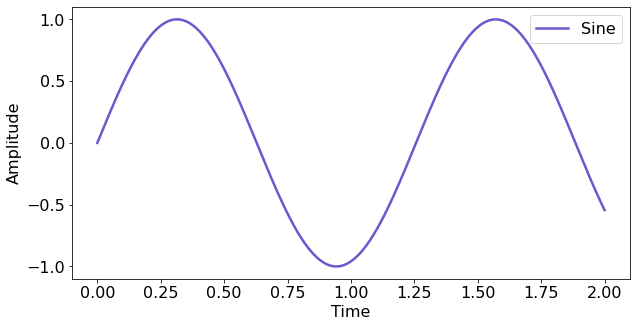

In [4]:
plt.figure(figsize=figsize)
plt.plot(time, sine(1, 5, 0, time), linewidth=linewidth,color="slateblue",  label="Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
#plt.savefig("sine.pdf" ,bbox_inches='tight')
plt.show()

We can subsequently plot the FFT of the sine. Notice the spectral leakage in the plot.

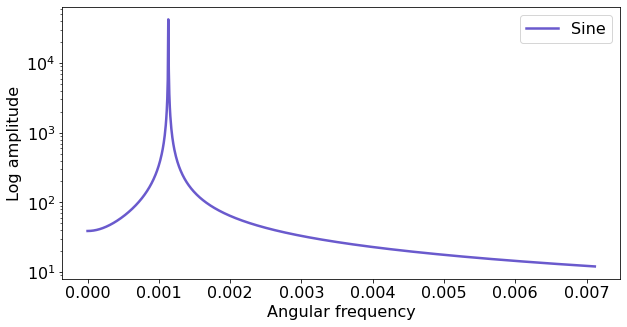

In [5]:
plt.figure(figsize=figsize)
plt.plot(fourier[:1000], np.abs(fft(sine(1, 500, 0, time)))[:1000], linewidth=linewidth,color="slateblue",  label="Sine")
plt.xlabel("Angular frequency")
plt.ylabel("Log amplitude")
plt.yscale("log")
plt.legend(loc='upper right')
#plt.savefig("sine_fft.pdf",bbox_inches='tight')
plt.show()

In [6]:
write_audio(sine(1, 0.05, 0, samples), "samples/sine.wav")

### 1.2. Square wave

The square wave is simply as signal alternating between $-A$ and $+A$. Its equation can be simply written as

\begin{align*}
    square[A, \omega_c, \phi;n] = A \cdot sgn \left( \sin (\omega_c n -\phi \right) ).
\end{align*}

This implementation is very simple and can be efficiently coded for digital synthesizers. 

In [7]:
def square(A, w, phi, n):
    return A*np.sign( np.sin( w*n - phi))

The corresponding additive oscialltor equation reads
\begin{align*}
    square[A, \omega_c, \phi;n] = \frac{4A}{\pi} \sum_{k=1}^{\infty} \frac{ \sin ((2k-1)\omega_c n - \phi)}{2k - 1} ,
\end{align*}
where the infinite sum is in practice approximated with a high order.

In [8]:
def square_sin(A, w, phi, n, order=20):
    out = 0
    for k in range(1, order+1):
        out += np.sin((2*k-1)*w*n - phi)/(2*k-1)
        
    return 4*A/np.pi * out

The square wave has a lot of harmonics that decrease slowly in amplitude. This give the square wave a sharper, brighter sound than the sine wave. The square wave was used a lot in early videogames consoles, such as the Commodore 64, and is now often associated with retro games music, or *chiptune*. In the figure are compared a digital square wave, generated directly using the exact equation described above, as well as its additive synthesis approximation. One can observe in the FFT plot that only the $k$ first harmonics of the square wave are generated.

In [9]:
@widgets.interact(order=(1, 20, 1))
def update(order=10):

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(time, square_sin(1, 5, 0, time, order), linewidth=linewidth, color="orange", label="Additive square")
    ax.plot(time, square(1, 5, 0, time), linewidth=linewidth, color="slateblue", label="Digital square")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    #plt.savefig("square.pdf",bbox_inches='tight')
    plt.show()

interactive(children=(IntSlider(value=10, description='order', max=20, min=1), Output()), _dom_classes=('widge…

An issue that is met when generating a square wave using additive synthesis is the **Gibbs phenomenon**. This phenomenon corresponds to the apparition of small vertical spikes at the corners of the square wave. An interactive animation from Dr. Prandoni's introductory DSP class highlights the Gibbs phenomenon for classical waveforms: https://www.sp4comm.org/gibbs/gibbs.html. The phenomenon highlights the fact that Fourier series can describe perfectly any smooth function, but meet limitations with non smooth functions, such as the square wave. Indeed, the additive synthesis square wave does not converge to the digital square wave, even for $k \rightarrow \infty$, and A spike measuring approximately $18\%$ of the amplitude $A$ is always observed for arbitrary great values of $k$. This however does not generate problems from an audio point of view, as the sound of a square wave with spikes is generally considered similar to the sound of a digital square wave. Most additive synthesis synthesizer hence simply use this formula for generating square waves.

In [10]:
@widgets.interact(order=(1, 20, 1))
def update(order=10):

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(fourier[:1000], np.abs(fft(square(1, 50, 0, time)))[:1000], linewidth=linewidth,color="slateblue",  label="Digital square")
    ax.plot(fourier[:1000], np.abs(fft(square_sin(1, 50, 0, time, order)))[:1000], linewidth=linewidth, color="orange", label="Additive square")
    plt.xlabel("Angular frequency")
    plt.ylabel("Log amplitude")
    plt.yscale("log")
    plt.legend(loc='upper right')
    #plt.savefig("square_fft.pdf",bbox_inches='tight')
    plt.show()

interactive(children=(IntSlider(value=10, description='order', max=20, min=1), Output()), _dom_classes=('widge…

In [11]:
write_audio(square(1, 0.05, 0, samples), "samples/square.wav")

### 1.3. Sawtooth wave

The sawtooth wave first increases linearly from $-A$ to $+A$ and then instantly jumps back to $-A$. This is digitally written as

\begin{align*}
    saw[A, \omega_c, \phi;n] = \frac{2A}{\pi} \arctan ( \tan (\omega_c n/2 - \phi) ) .
\end{align*}

In [12]:
def saw(A, w, phi, n):
    return 2*A/np.pi * np.arctan( np.tan( w*n/2 - phi))

Similarly as for the square wave, analog synthesizer approximate this wave using additive synthesis as

\begin{align*}
    saw[A, \omega_c, \phi;n] = -\frac{2A}{\pi} \sum_{k=1}^{\infty} \frac{(-1)^k}{k}\sin (k \omega_c n - \phi) .
\end{align*}

In [13]:
def saw_sin(A, w, phi, n, order=20):
    out = 0
    for k in range(1, order+1):
        out += (-1)**k/k * np.sin( k*w*n - phi )
        
    return - 2*A/np.pi * out

One can remark that the Gibbs phenomenon is present as for the square wave, since the sawtooth contains a vertical discontinuity.  The sawtooth wave has a very crispy, aggressive sound and is for that reason quite popular in Trance and House electronic music.

In [14]:
@widgets.interact(order=(1, 20, 1))
def update(order=10):

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(time, saw_sin(1, 5, 0, time, order), linewidth=linewidth, color="orange", label="Additive saw")
    ax.plot(time, saw(1, 5, 0, time), linewidth=linewidth, color="slateblue", label="Digital saw")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    #plt.savefig("saw.pdf",bbox_inches='tight')
    plt.show()

interactive(children=(IntSlider(value=10, description='order', max=20, min=1), Output()), _dom_classes=('widge…

In [15]:
@widgets.interact(order=(1, 20, 1))
def update(order=10):

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(fourier[:1000], np.abs(fft(saw(1, 50, 0, time)))[:1000], linewidth=linewidth, color="slateblue", label="Digital saw")
    ax.plot(fourier[:1000], np.abs(fft(saw_sin(1, 50, 0, time, order)))[:1000], linewidth=linewidth, color="orange", label="Additive saw")
    plt.xlabel("Angular frequency")
    plt.ylabel("Log amplitude")
    plt.yscale("log")
    plt.legend(loc='upper right')
    #plt.savefig("saw_fft.pdf",bbox_inches='tight')
    plt.show()

interactive(children=(IntSlider(value=10, description='order', max=20, min=1), Output()), _dom_classes=('widge…

In [16]:
write_audio(saw(1, 0.05, 0, samples), "samples/saw.wav")

### 1.4. Triangle wave

The triangle wave is an alternatively increasing then decreasing linear signal between $-A$ and $+A$. It is digitally written as

\begin{align*}
    tri[A, \omega_c, \phi ;n] = \frac{2A}{\pi} \arcsin ( \sin (\omega_c n - \phi) ).
\end{align*}

In [17]:
def triangle(A, w, phi, n):
    return 2*A/np.pi * np.arcsin( np.sin( w*n - phi))

The corresponding additive synthesis implementation reads

\begin{align*}
    tri[A, \omega_c, \phi;n] = \frac{8A}{\pi^2} \sum_{k=0}^\infty \frac{ (-1)^k }{ (2k + 1)^2} \sin ((2k + 1) \omega_c n - \phi).
\end{align*}

In [18]:
def triangle_sin(A, w, phi, n, order=20):
    out = 0
    for k in range(order):
        out += (-1)**k/(2*k+1)**2 * np.sin( (2*k+1)* w*n - phi )
        
    return 8*A/np.pi**2 * out

The triangle wave having no vertical jump, the Gibbs phenomenon is not significant. The additive approximation converges faster than the sawtooth and the square wave towards the digital implementation. One can notice that with $k=2$, the approximation is already quite close to the digital wave. The triangle wave has a sound in between the smoothness of sine and the brightness of a sawtooth. 

In [19]:
@widgets.interact(order=(1, 20, 1))
def update(order=2):

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(time, triangle_sin(1, 5, 0, time, order), linewidth=linewidth, color="orange", label="Additive triangle")
    ax.plot(time, triangle(1, 5, 0, time), linewidth=linewidth, color="slateblue", label="Digital triangle")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    #plt.savefig("triangle.pdf",bbox_inches='tight')
    plt.show()

interactive(children=(IntSlider(value=2, description='order', max=20, min=1), Output()), _dom_classes=('widget…

In [20]:
@widgets.interact(order=(1, 20, 1))
def update(order=2):

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(fourier[:1000], np.abs(fft(triangle(1, 50, 0, time)))[:1000], linewidth=linewidth, color="slateblue", label="Digital triangle")
    ax.plot(fourier[:1000], np.abs(fft(triangle_sin(1, 50, 0, time, order)))[:1000], linewidth=linewidth, color="orange", label="Additive triangle")
    plt.xlabel("Angular frequency")
    plt.ylabel("Log amplitude")
    plt.yscale("log")
    plt.legend(loc='upper right')
    #plt.savefig("triangle_fft.pdf",bbox_inches='tight')
    plt.show()

interactive(children=(IntSlider(value=2, description='order', max=20, min=1), Output()), _dom_classes=('widget…

In [21]:
write_audio(triangle(1, 0.05, 0, samples), "samples/triangle.wav")

## 2. FM synthesis oscillator

Alternatively to the additive synthesis, another sound creation scheme is FM synthesis. FM synthesis relies on Frequency Modulation (FM) as used in radio broadcast. An oscillator produces a waveform, called **the carrier**, that is then modulated with another waveform, called **the modulator**. The carrier is generally a sine wave, while the modulator can have any shape. In FM broadcasting, the carrier has a much higher frequency than the modulator. In FM synthesis, both the carrier and modulator signals have similar, audible frequencies. The carrier wave determines the pitch of the produced note, and the modulator determines its timbre. The equation of modulating a sine carrier with amplitude $A_C$, angular frequency $\omega_C$ and zero phase with an arbitrary modulator wave $x[n]$ reads

\begin{align*}
    y[n] = A_C \cdot \sin \left( \omega_C n + 2 \pi K_f \cdot x[n] \right)
\end{align*}

where $K_f$ is the modulation index, the sensitivity of the frequency modulator.

The output of the modulation can be used as the input of a subsequent modulation (or itself!), and different dispositions of modulator networks can generate different sounds. Modulations can be done in series and parallel and each output can be connected to any input. The behaviour of a modulation network is quite hard to predict, and generally the user experiments with different networks and parameters until they find a satisfying sound.

In [22]:
def modulator(cw, cA, mod_signal, mod_index=1):
    """
    Block modulating a sine carrier with a modulator.
    cw: the angular frequency of the sine carrier
    cA: the amplitude of the sine carrier
    mod_signal: the arbitrary modulator signal
    mod_index: the modulation index Kf
    """
    return np.array([cA * np.sin(cw*i + mod_index*2.*np.pi*mod_signal[i]) for i in range(mod_signal.size)])

We can now try to modulate several sine signals together and oberseve how complex the waveform becomes after only a couple iterations!

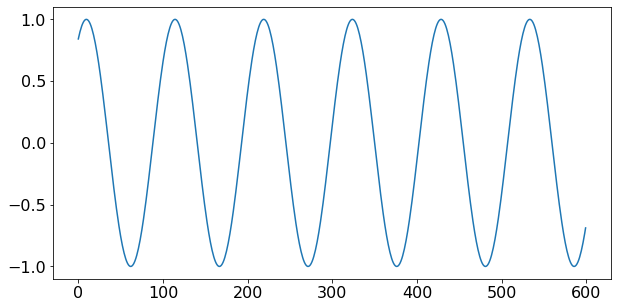

In [23]:
sine1 = sine(A=1, w=0.06, phi=-1, n=np.arange(2*fs, dtype=np.float32))
plt.figure(figsize=figsize)
plt.plot(sine1[:600])
plt.show()
write_audio(sine1, "samples/sine1.wav")

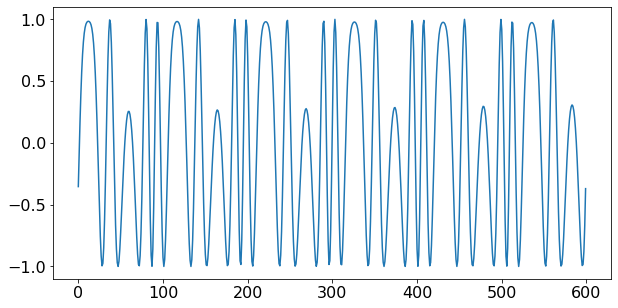

In [24]:
sine2 = modulator(cw=0.0599, cA=1, mod_signal=sine1, mod_index=1.12)
plt.figure(figsize=figsize)
plt.plot(sine2[:600])
plt.show()
write_audio(sine2, "samples/sine2.wav")

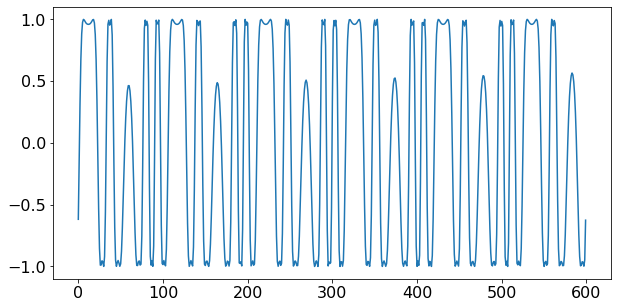

In [25]:
sine3 = modulator(.000037, 1, sine2, mod_index=.3)
plt.figure(figsize=figsize)
plt.plot(sine3[:600])
plt.show()
write_audio(sine3, "samples/sine3.wav")

## 3. Working with LFOs

A Low Frequency Oscillator (LFO) is, as the name suggests, an oscillator which operates at a low frequency, generally within $(0, 20]$Hz. LFOs are generally generated using one of the waveforms presented in the above section, and that for all types of synthesizers. For instance, although FM synthesizers do not use waveform oscillators for generating the source sound, they generally still use waveforms for the LFO. Oppositely to a standard oscillator, a LFO does not generate a sound, but is used to automatically control a parameter inside of the synthesizer and to make it change over time. Virtually, any parameter of the amplifier can be controlled by a LFO (even the LFO parameters themselves). For instance, a LFO can be used to automatically control the synthesizer's master volume, to create a tremolo, or to control the phaseof the main oscillator to create a vibrato.

### 3.1. Tremolo

Let's first use a LFO to control the tremolo over a sine wave. We simply use the output of the LFO as the input of the amplitude of the oscillator.

In [26]:
@widgets.interact(lfo_speed=(.0001, .005, .0001))
def update(lfo_speed=.0015):

    lfo1 = sine(1, lfo_speed, 0, samples) # Low freqency oscillator
    lfo_tremolo = square(lfo1, .06, 0, samples) # LFO'ed sine wave

    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(lfo_tremolo[:5000])
    plt.show()

interactive(children=(FloatSlider(value=0.0015, description='lfo_speed', max=0.005, min=0.0001, step=0.0001), …

In [27]:
lfo = sine(1, .0003, 0, samples) # Low freqency oscillator
lfo_tremolo = square(lfo, .06, 0, samples) # LFO'ed sine wave
write_audio(lfo_tremolo, "samples/lfo_tremolo.wav")

### 3.2. Vibrato

One can also program the phase of an oscialltor with a LFO to create a vibrato.

In [28]:
@widgets.interact(lfo_speed=(0.00001, .01, 0.0005))
def update(lfo_speed=0.007):

    lfo1 = sine(5, lfo_speed, 0, samples) # Low freqency oscillator
    lfo_square1 = square(1, 0.06, lfo1, samples) # LFO'ed sine wave

    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(lfo_square1[:5000])
    plt.show()

interactive(children=(FloatSlider(value=0.007, description='lfo_speed', max=0.01, min=1e-05, step=0.0005), Out…

In [29]:
lfo= sine(5, .0005, 0, samples) # Low freqency oscillator
lfo_vibrato = square(1, 0.06, lfo, samples) # LFO'ed sine wave
write_audio(lfo_vibrato, "samples/lfo_vibrato.wav")